In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf


import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def spearmanr(x, y):
    rx = x.argsort().argsort()
    ry = y.argsort().argsort()
    return torch.corrcoef(torch.stack([rx.float(), ry.float()]))[0, 1]

In [3]:
def dists_and_errors(cfg, num_samples=1000, return_xy=False):

    # build models + dataset
    encoder_cfg = cfg['config']['encoder']
    generator_cfg = cfg['config']['generator']
    dataset_cfg = cfg['config']['dataset']
    
    encoder = hydra.utils.instantiate(encoder_cfg)
    generator = hydra.utils.instantiate(generator_cfg)
    dataset = hydra.utils.instantiate(dataset_cfg)

    # load model weights

    if not os.path.exists(cfg['dir']+'/best_model.pt'):
        print('No best model file...')
        return "No best model file..."
    
    best_model = load_best_model(cfg['dir'])
    encoder.load_state_dict(best_model['encoder_state_dict'])
    generator.model.load_state_dict(best_model['generator_state_dict'])

    with torch.no_grad():
        # grab data + encode
        x = torch.tensor(dataset.data[:num_samples], dtype=torch.float32)
        z = encoder(x)

        # fisher rao + L2 distances
        fr = torch.tensor(dataset.fisher_rao_distance(dataset.mu[:num_samples],
                                                      dataset.var[:num_samples]))
        zl2 = torch.cdist(z, z, p=1)

        # just upper triangle
        fr_vals = fr.triu(1)[fr.triu(1) != 0]
        l2_vals = zl2.triu(1)[zl2.triu(1) != 0]
        xy = torch.stack([fr_vals, l2_vals], dim=1)

        # generate + compare stats
        samples = generator.sample(z, num_samples)
        mean_mse = ((samples.mean(dim=1) - dataset.mu[:num_samples])**2).mean().item()
        var_mse = ((samples.var(dim=1) - dataset.var[:num_samples])**2).mean().item()

        # compute rank corr
        spearman_r = spearmanr(xy[:, 0], xy[:, 1]).item()

    # say hi
    print(cfg['encoder'])
    print(cfg['generator'])
    print('spearman r:', spearman_r)
    print('mean mse:', mean_mse)
    print('var mse:', var_mse)

    return {
        'encoder': cfg['encoder'],
        'generator': cfg['generator'],
        'spearman_r': spearman_r,
        'mean_mse': mean_mse,
        'var_mse': var_mse,
        'xy': xy if return_xy else None,
    }


N_dims: 2
DistributionEncoderGNN
DirectGenerator
spearman r: 0.47318416833877563
mean mse: 0.01939811444009891
var mse: 0.11221536203856966
4
N_dims: 4
DistributionEncoderGNN
DirectGenerator
spearman r: 0.22432047128677368
mean mse: 0.013226859759769817
var mse: 0.07731887377316209
6
N_dims: 4
DistributionEncoderTx
DirectGenerator
spearman r: 0.25145891308784485
mean mse: 0.01414692109630843
var mse: 0.08532180673346805
2
N_dims: 2
DistributionEncoderTx
DirectGenerator
spearman r: 0.4736710786819458
mean mse: 0.017104542993314077
var mse: 0.13324877701234406
0
N_dims: 3
DistributionEncoderTx
DirectGenerator
spearman r: 0.34061869978904724
mean mse: 0.015414095696986901
var mse: 0.09498042931433172
1
N_dims: 3
DistributionEncoderGNN
DirectGenerator
spearman r: 0.28038135170936584
mean mse: 0.0154345851160296
var mse: 0.10789923873082277
5
N_dims: 5
DistributionEncoderTx
DirectGenerator
spearman r: 0.21983610093593597
mean mse: 0.014603527080609253
var mse: 0.08710914117942639
3
N_dims: 

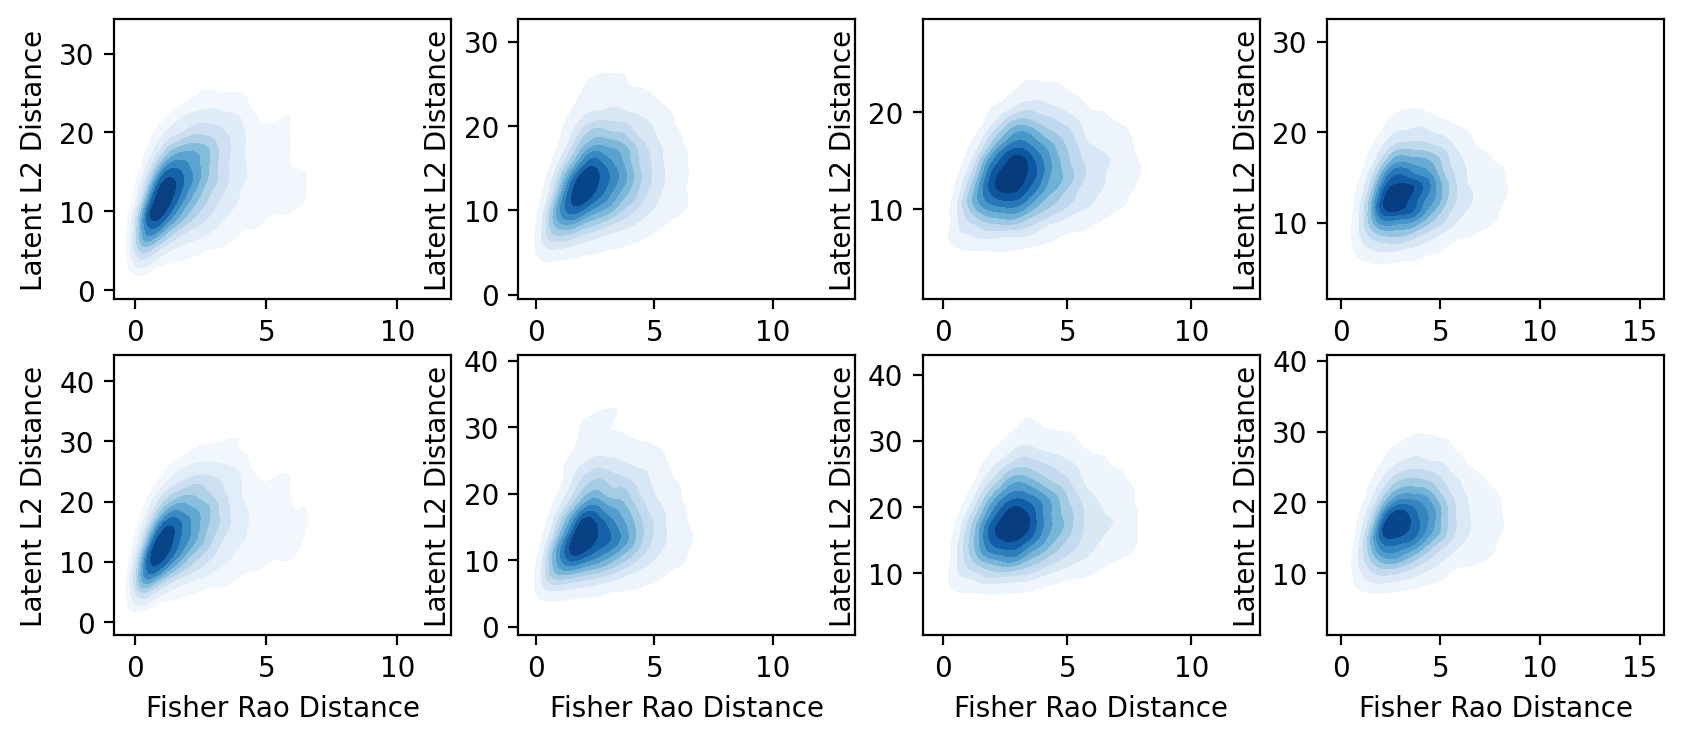

In [5]:
base_dir = 'outputs/'
configs = get_all_experiments_info(base_dir, False)
simple_configs = [c  for c in configs if 'simple' in c['name']]


fig, axs = plt.subplots(2, 4, figsize=(10, 4), dpi=200)

for c in simple_configs:
    if c['config']['training']['num_epochs'] > 20:

        N_dims = c['config']['dataset']['data_shape'][0]
        print('N_dims:', N_dims)

        d = dists_and_errors(c, num_samples=200, return_xy=True)
        
        x, y = d['xy'][:, 0], d['xy'][:, 1]


        i = 'GNN' in d['encoder']
        j = N_dims - 2

        ax = axs.flatten()[i * 4 + j]

        print(i*4+j)

        sns.kdeplot(x=x, y=y, levels=10, ax=ax, cmap='Blues', 
                    fill=True, thresh=0.05)
        ax.set_xlabel('Fisher Rao Distance')
        ax.set_ylabel('Latent L2 Distance')
        # ax.set_title(d['encoder']+'+'+d['generator']+', '+str(N_dims)+'dims')

plt.show()

In [38]:
cfg = simple_configs[0]
num_samples = 200

# build models + dataset
encoder_cfg = cfg['config']['encoder']
generator_cfg = cfg['config']['generator']
dataset_cfg = cfg['config']['dataset']

encoder = hydra.utils.instantiate(encoder_cfg)
generator = hydra.utils.instantiate(generator_cfg)
dataset = hydra.utils.instantiate(dataset_cfg)

# load model weights

if not os.path.exists(cfg['dir']+'/best_model.pt'):
    print('No best model file...')

best_model = load_best_model(cfg['dir'])
encoder.load_state_dict(best_model['encoder_state_dict'])
generator.model.load_state_dict(best_model['generator_state_dict'])

with torch.no_grad():
    # grab data + encode
    x = torch.tensor(dataset.data[:num_samples], dtype=torch.float32)
    z = encoder(x)

    # fisher rao + L2 distances
    fr = torch.tensor(dataset.fisher_rao_distance(dataset.mu[:num_samples],
                                                    dataset.var[:num_samples]))
    zl2 = torch.cdist(z, z, p=1)

In [40]:
s = (dataset.mu[:num_samples]**2).sum(axis=1)
m = s[:, None] + s
s = (dataset.var[:num_samples]).sum(axis=1)
v = s[:, None] + s
t = v+s

Text(0, 0.5, 'FR - L2')

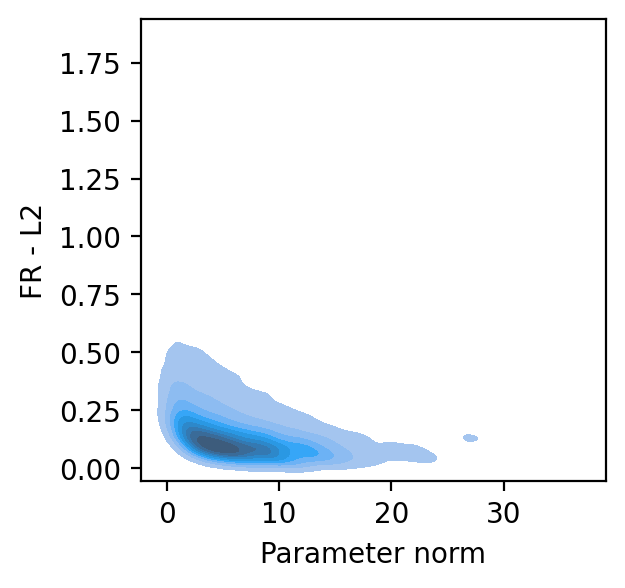

In [50]:
fig = plt.figure(figsize=(3, 3), dpi=200)
sns.kdeplot(x=t.flatten(), 
            y=(fr/zl2).flatten(),
            levels=10, fill=True)
plt.xlabel('Parameter norm')
plt.ylabel('FR - L2')

<Axes: xlabel='None', ylabel='None'>

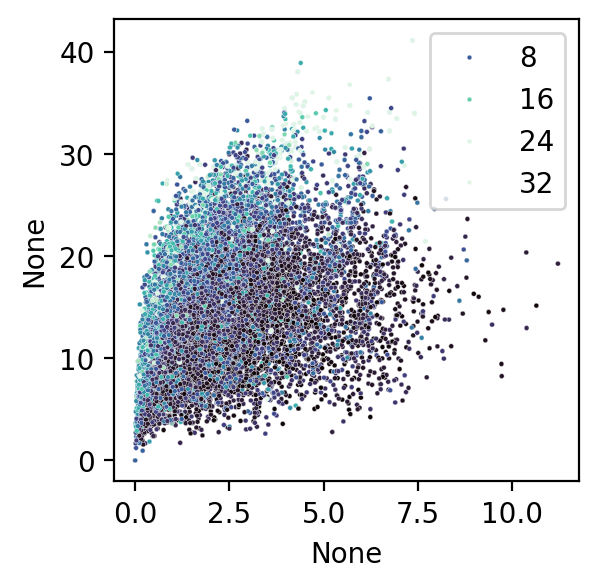

In [49]:
fig = plt.figure(figsize=(3,3), dpi=200)
sns.scatterplot(x=fr.flatten(),
            y=zl2.flatten(),
            hue=t.flatten(), palette='mako', s=3, hue_norm=(0, 20))